In [2]:
# Common loss class
class Loss:
    # Calculates the data and regularization losses
    def regularization_loss(self):
        # 0 by default
        regularization_loss = 0

        # Calculate regularization loss
        # itrate all trainable layers
        for layer in self.trainable_layers:
        
            # L1 regularization - weights
            # calculate only when factor greater than 0
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
    
            # L2 regularization - weights
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
    
            # L1 regularization - biases
            # calculate only when factor greater than 0
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            # L2 regularization - biases
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(np.abs(layer.biases * layer.biases))
    
        return regularization_loss

    # Set/remember trainable layers
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers
    
    # given model output and ground truth values
    def calculate(self, output, y, *, include_regularization=False):
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Add accumulated sum of losses and sample count
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)

        # If just data loss - return it
        if not include_regularization:
            return data_loss

        # Return loss and regularization loss
        return data_loss, self.regularization_loss()

    # Calculates accumulated loss
    def calculate_accumulated(self, *, include_regularization=False):
        # Calculate mean loss
        data_loss = self.accumulated_sum / self.accumulated_count
        # If just data loss - return it
        if not include_regularization:
            return data_loss
        # Return the data and regularization losses
        return data_loss, self.regularization_loss()

    # Reset variables for accumulated loss
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

In [3]:
# Binary cross-entropy loss
class Loss_BinaryCrossEntropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        clipped_values = np.clip(dvalues, 1e-7, 1-1e-7)
        # Calculate gradient
        self.dinputs = -((y_true / clipped_values) - (1 - y_true) / (1 - clipped_values)) / outputs
        self.dinputs = self.dinputs / samples

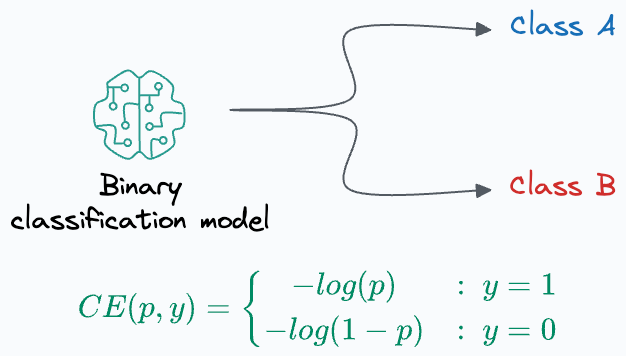